# Airbnb-AI
A ml-project to predict rent of an airbnb flat in Barcelona
Nils Liebrand, Till Malte Friedrich, Than Tran

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews_2.csv


In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


# Extracing the data

In [3]:
listing_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv', encoding="latin1")
listing_details_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv' , encoding="latin1")
review_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv' , encoding="latin1")
geo_data = gpd.read_file('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson')


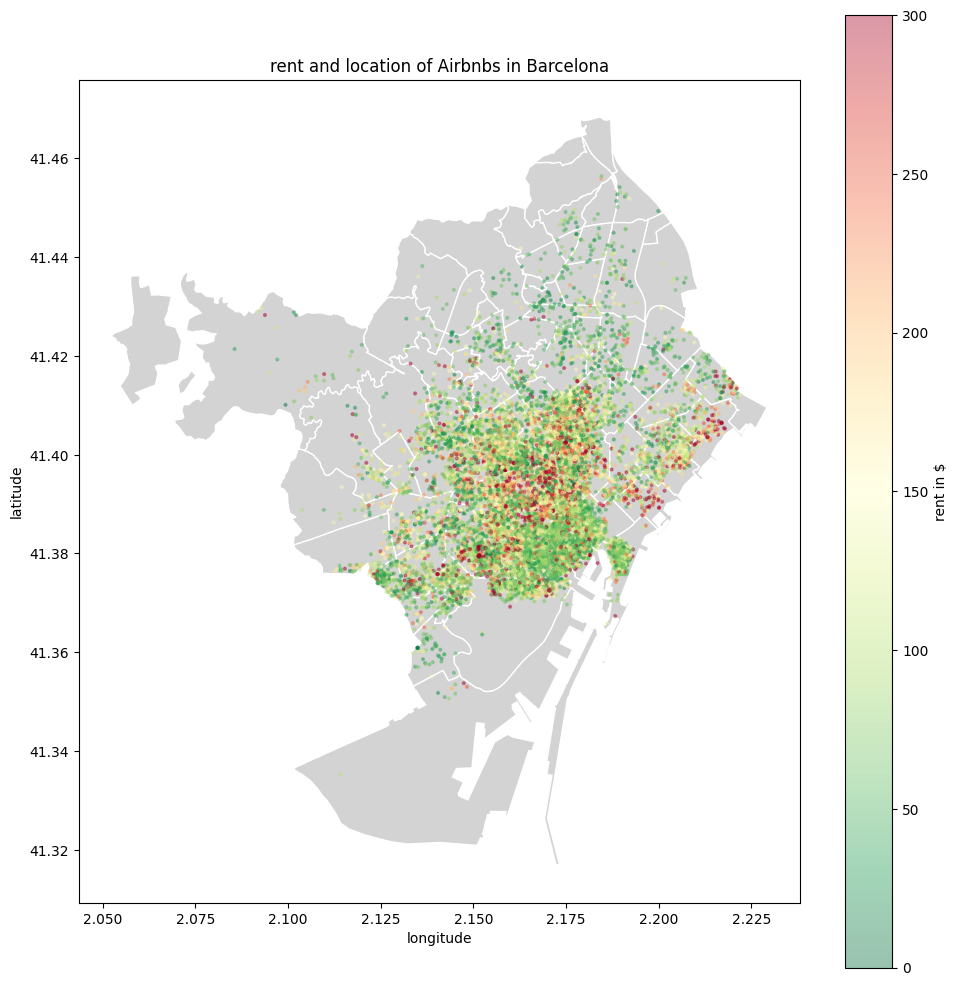

In [4]:
#visualizing the data
longitudes = listing_data["longitude"]
latitudes = listing_data["latitude"]
prices = listing_data["price"]

fig, ax = plt.subplots(figsize=(10, 10))
geo_data.plot(ax=ax, color='lightgrey', edgecolor='white')

sc = ax.scatter(
    listing_data["longitude"],
    listing_data["latitude"],
    c=listing_data["price"],
    cmap='RdYlGn_r',
    s=4,
    vmin=0,
    vmax=300,
    alpha=0.4
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('rent in $')
plt.xlabel("longitude")
plt.ylabel("latitude")

ax.set_title("rent and location of Airbnbs in Barcelona")
plt.tight_layout()
plt.show()

### Processing the data

In [5]:
#listings
#remove unnecessary data
columns_to_remove = ['listing_url', 'scrape_id', 'host_url', 'host_id' ,  'last_scraped', 'source', 'bathrooms_text', 'calendar_updated', 'calendar_last_scraped']
listing_details_data = listing_details_data.drop(columns=columns_to_remove)
listing_data = listing_data.drop(columns='id')



#find dublicates
column_names = listing_data.columns.tolist()
for column in column_names:
    #id needed for merging
    if column in listing_details_data.columns.tolist():
        listing_details_data = listing_details_data.drop(columns = column)

listing_data = pd.concat([listing_data, listing_details_data], axis=1)

#expanding listing data amenities list into inidividual rows
#TODO - fix amenities categories to make data less sparse (different spelling, translations, redundancy, ...)
amenities_df = listing_data[['amenities']].copy()
amenities_df['amenities'] = amenities_df['amenities'].apply(ast.literal_eval)
all_amenities = set()
amenities_df['amenities'].apply(lambda x: all_amenities.update(x))
all_amenities = sorted(all_amenities) 

for amenity in all_amenities:
    col_name = f"amenity_{amenity.lower().replace(' ', '_').replace('-', '_')}"
    amenities_df[col_name] = amenities_df['amenities'].apply(lambda x: amenity in x)

amenities_df = amenities_df.drop('amenities', axis=1)
print(amenities_df[:5])
listing_data = listing_data.drop(columns='amenities')
listing_data = pd.concat([listing_data, amenities_df], axis=1)

#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)

        

#reviews
#remove unnecessary data
columns_to_remove = ['id', 'reviewer_id']
review_data = review_data.drop(columns = columns_to_remove)

print(listing_data[:5])

#TODO - replace nan and missing values.
#TODO - text to numerical data
#TODO - One hot encoding for host verification types
#TODO - Change all text to strict ascii 


   amenity_\tikea_lagan_10567926_refrigerator  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   amenity__bonté_or_similar/shampoo_+_conditioner_shampoo  \
0                                              False         
1                                              False         
2                                              False         
3                                              False         
4                                              False         

   amenity__neutro__body_soap  amenity___body_soap  amenity_._body_soap  \
0                       False                False                False   
1                       False                False                False   
2                       False                False                False   
3                       False   

### Handling categorial and image data

In [6]:
#extracting categories
category_dict = {}
category_data_columns = ['neighbourhood_group', 'neighbourhood', 'room_type', 'instant_bookable', 'license', 'host_location', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'has_availability', 'instant_bookable', ]
for column in category_data_columns:
    column_categories = []
    for x in listing_data[column]:
        if x not in column_categories:
            column_categories.append(x)
    category_dict[column] = column_categories
category_dict

{'neighbourhood_group': ['Eixample',
  'Sant MartÃ\xad',
  'GrÃ\xa0cia',
  'Ciutat Vella',
  'Sants-MontjuÃ¯c',
  'Les Corts',
  'Horta-GuinardÃ³',
  'Sant Andreu',
  'SarriÃ\xa0-Sant Gervasi',
  'Nou Barris'],
 'neighbourhood': ['la Sagrada FamÃ\xadlia',
  'el BesÃ²s i el Maresme',
  "el Camp d'en Grassot i GrÃ\xa0cia Nova",
  'el Barri GÃ²tic',
  'la Barceloneta',
  "la Dreta de l'Eixample",
  "el Camp de l'Arpa del Clot",
  'Vallcarca i els Penitents',
  'el Raval',
  'el Poblenou',
  'el Clot',
  'el Poble Sec',
  'Sant Antoni',
  'Sant Pere, Santa Caterina i la Ribera',
  'Sants',
  'Pedralbes',
  'el GuinardÃ³',
  "l'Antiga Esquerra de l'Eixample",
  'la Vila de GrÃ\xa0cia',
  'Diagonal Mar i el Front MarÃ\xadtim del Poblenou',
  'el Fort Pienc',
  'Sant MartÃ\xad de ProvenÃ§als',
  'Navas',
  "la Nova Esquerra de l'Eixample",
  'SarriÃ\xa0',
  'el Coll',
  'el Parc i la Llacuna del Poblenou',
  'la Vila OlÃ\xadmpica del Poblenou',
  'les Corts',
  'el Putxet i el FarrÃ³',
  'San

## Train the model
### Linear Regression